# Atividade 7

Nesta atividade iremos realizar alguns testes com o classificador SVM na nossa base de dados, adaptando-o de acordo com as características da nossa base.


## 0. Preparação do ambiente.
Para os trabalhos desta atividade utilizaremos a base de dados previamente carregada no Github, [neste link](https://github.com/danielbdias/pattern-recognition-studies.git), em conjunto com alguns scripts auxiliares

In [1]:
# prepara a máquina local do google colab para receber a base (quando necessário)
# e baixa os scripts auxiliares para a montagem do notebook
#!rm -rf ./*

#!git clone https://github.com/danielbdias/pattern-recognition-studies.git
#!mv ./pattern-recognition-studies/* ./
#!rm -rf ./pattern-recognition-studies
#!rm -rf ./sample_data

#!pip install -r requirements.txt

In [2]:
# imports de libs necessárias para as análises
from scripts.database import load_datapoints_with_targets
from scripts.preprocessing import centralize_observations, principal_component_analysis
from scripts.classification import run_classifier_with_stratified_k_fold
from scripts.graphics import plot_metric

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import numpy as np
import pandas as pd
import pickle

## 1. Base de dados

Para o nosso trabalho, estamos utilizando o dataset [Grammatical Facial Expressions](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions), que descreve expressões faciais gramaticais da linguagem brasileira de sinais (Libras).

A base possui `27965 instâncias`, subdivididas em 9 expressões: `Interrogativa (qu)`,`Interrogativa (s/n)`, `Interrogativa (dúvida)`, `Negativa`, `Afirmativa`, `Condicional`, `Relativa`, `Tópico` e `Foco`. 

Cada instância é estruturada em `300 características`, que representam 100 pontos com coordenadas (x, y, z) da face, seguindo a ordem abaixo:

| Coordenadas (x,y,z) | Região da Face | Coordenadas (x,y,z) | Região da Face |
| --- | --- | --- | --- |
| 0 - 7 (x,y,z) | olho esquerdo | 68 - 86 (x,y,z) | contorno da face |
| 8 - 15 (x,y,z) | olho direito | 87 (x,y,z) | iris esquerda |
| 16 - 25 (x,y,z) | sobrancelha esquerda | 88 (x,y,z) | iris direita |
| 26 - 35 (x,y,z) | sobrancelha direita | 89 (x,y,z) | ponta do nariz |
| 36 - 47 (x,y,z) | nariz | 90 - 94 (x,y,z) | linha acima da sobrancelha esquerda |
| 48 - 67 (x,y,z) | boca | 95 - 99 (x,y,z) | linha acima da sobrancelha direita |

Não há missing values nesses pontos e eles não por um processo de normalização. A classificação de instância é binária onde ela pode ser "Com Expressão" (`"Expression"`, onde os pontos representam a expressão facial) ou "Sem Expressão" (`"Not Expression"`, os pontos não representam uma expressão).

Normalizamos a base buscando centralizar cada frame (observação) em relação a um ponto em comum no frame.
Escolhemos o ponto 89 (`nose tip`) como referência e aplicamos o processo nas seguintes etapas:

1.   Encontramos os valores médios para o ponto 89 nos valores de `x` e `y` (ignoramos o valor de `z` por ele usar uma medida em milimetros ao invés de em pixels, [referência](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions#));
2.   Calculamos os deltas do ponto 89 de cada observação em relação aos valores médios encontrados;
3.   Subtraimos esse delta de todos os pontos de cada observação.

Nesta atividade utilizaremos somente as observações da expressão facial `negativa` em sua forma pré-processada (com os pontos centralizados) de quatro formas diferentes:

- Base com todas as características
- Base transformada pela técnica PCA (resultante da Atividade 03)
- Base com as características encontradas pelo Relief-F (resultante da Atividade 04)
- Base com as características encontradas pelo Algoritmo Genético (resultante da Atividade 04)


### 1.1 Base total (todas as características)

A base de dados com todas as características contém 300 dimensões, estruturadas da seguinte forma:

In [3]:
category = 'negative'
raw_data = load_datapoints_with_targets(category)

dataset = centralize_observations(raw_data)
dataset.describe()

/Users/daniebdias/Development/Repositories/studies/doctorate/pattern-recognition/scripts/database.py:9: FutureWarning: read_table is deprecated, use read_csv instead.
  a = pd.read_table(f'{database_dir}/a_{category}_datapoints.txt', sep = ' ')
/Users/daniebdias/Development/Repositories/studies/doctorate/pattern-recognition/scripts/database.py:10: FutureWarning: read_table is deprecated, use read_csv instead.
  b = pd.read_table(f'{database_dir}/b_{category}_datapoints.txt', sep = ' ')
/Users/daniebdias/Development/Repositories/studies/doctorate/pattern-recognition/scripts/database.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  a = pd.read_table(f'{database_dir}/a_{category}_targets.txt', sep = ' ', header = None, names = ['target'])
/Users/daniebdias/Development/Repositories/studies/doctorate/pattern-recognition/scripts/database.py:17: FutureWarning: read_table is deprecated, use read_csv instead.
  b = pd.read_table(f'{database_dir}/b_{category}_targets.txt',

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,...,97x,97y,97z,98x,98y,98z,99x,99y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,309.397827,219.230181,1060.284922,306.747875,217.450552,1131.164819,303.378426,216.894622,1193.764597,300.074385,...,336.213900,205.329225,1272.370658,341.628362,207.474289,1184.382114,344.936643,210.218903,986.881744,0.458241
std,1.625597,2.741896,439.370887,1.766325,2.647455,361.558210,1.909747,2.545192,266.930040,2.068360,...,3.905090,5.389459,89.417381,3.914957,6.521451,351.531081,3.385256,7.330508,555.178027,0.498345
min,303.950854,209.797120,0.000000,300.704854,207.540120,0.000000,296.182854,206.904120,0.000000,291.035854,...,324.399854,191.588120,0.000000,329.433854,190.305120,0.000000,333.625854,190.429120,0.000000,0.000000
25%,308.392854,217.153620,1216.000000,305.627854,215.371120,1221.000000,302.096854,214.948620,1225.000000,298.725104,...,332.981354,200.486870,1265.000000,338.390354,201.331120,1275.000000,342.261354,203.145120,1208.000000,0.000000
50%,309.606354,219.179620,1238.000000,306.972854,217.450620,1243.000000,303.588354,217.093620,1256.000000,300.290354,...,335.892854,206.155620,1284.000000,341.439354,208.103120,1294.000000,345.075854,210.954620,1294.000000,0.000000
75%,310.441854,221.674620,1261.000000,307.857104,219.733870,1270.000000,304.494854,219.018620,1280.000000,301.115854,...,340.044854,210.090870,1294.000000,345.416854,213.098120,1299.000000,348.082604,216.895370,1309.000000,1.000000
max,314.504854,224.502120,1299.000000,312.710854,222.920120,1304.000000,310.230854,222.413120,1314.000000,307.853854,...,348.181854,214.912120,1329.000000,356.601854,219.077120,1542.000000,360.888854,223.073120,1563.000000,1.000000


### 1.2 Base com PCA

A base transformada pelo PCA, considerando apenas os componentes que representam até 80% da variabilidade dos dados, está estruturada da seguinte forma:

In [4]:
features = list(dataset.columns)

pca_results = principal_component_analysis(features, dataset.values)
number_of_chosen_components = len(pca_results.principal_components_under_threshold)
dataset_pca = pd.DataFrame(data=pca_results.X_transformed[:, 0:number_of_chosen_components], columns=pca_results.principal_components_under_threshold)
dataset_pca.insert(number_of_chosen_components, 'target', dataset["target"].values)

dataset_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,target
count,2706.000000,2.706000e+03,2706.000000,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2706.000000
mean,0.000000,-9.679766e-14,0.000000,2.688824e-15,6.453177e-14,-1.075530e-13,-4.571001e-14,1.814956e-14,-8.100082e-14,6.722060e-14,1.613294e-14,1.344412e-14,-5.175986e-14,5.444869e-14,0.458241
std,1529.487923,8.288783e+02,754.072116,6.260129e+02,5.462340e+02,5.340938e+02,4.957597e+02,4.435333e+02,4.423319e+02,4.176105e+02,4.015236e+02,3.878080e+02,3.717674e+02,3.621114e+02,0.498345
min,-2494.036515,-1.817949e+03,-1412.855471,-1.434314e+03,-1.577976e+03,-1.700658e+03,-1.627370e+03,-1.685620e+03,-1.570395e+03,-1.468439e+03,-1.255571e+03,-1.326306e+03,-1.290745e+03,-1.335360e+03,0.000000
25%,-1444.534931,-4.992440e+02,-583.204813,-3.655466e+02,-2.304158e+02,-1.815366e+02,-2.606310e+02,-1.866340e+02,-2.145056e+02,-2.447499e+02,-2.098125e+02,-2.325568e+02,-1.346116e+02,-1.685787e+02,0.000000
50%,357.944939,-4.997479e+01,-42.891897,-1.593658e+01,-6.683547e+00,-1.247349e+01,4.315854e+01,-3.389786e+00,-1.253438e+01,-8.601830e+00,-3.332489e+01,-3.781624e+00,-1.065275e+01,2.084432e+01,0.000000
75%,1319.487879,4.042879e+02,602.397126,3.635263e+02,2.743019e+02,1.803365e+02,2.353098e+02,1.880283e+02,1.721725e+02,2.301877e+02,1.991701e+02,2.275928e+02,1.171180e+02,1.320544e+02,1.000000
max,3017.776144,3.035289e+03,2526.584373,1.814297e+03,1.674262e+03,1.884368e+03,2.005806e+03,1.862771e+03,1.639981e+03,1.543912e+03,1.848362e+03,1.512133e+03,1.503722e+03,1.508445e+03,1.000000


### 1.3 Base com características selecionadas pelo Relief-F

A base com características selecionadas pelo Relief-F considerou as seguintes características:

In [5]:
features_chosen_by_relief = ['41x', '40x', '86x', '42x', '39x', '85x', '44x', '53y', '84x', '68x', '60x', '69x', '15x', '63y', '83x', '70x', '14x', 'target']
dataset_with_relief = dataset[features_chosen_by_relief]
dataset_with_relief.describe()

,41x,40x,86x,42x,39x,85x,44x,53y,84x,68x,60x,69x,15x,63y,83x,70x,14x,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,315.351416,309.820054,349.447013,319.569119,308.938044,349.895513,326.612842,242.286661,349.721362,289.396139,309.200498,289.235498,329.038068,243.888143,348.805798,289.878882,332.324666,0.458241
std,0.492467,0.543975,3.408376,0.574203,0.611865,3.360874,0.480513,1.163002,3.364616,4.203998,1.904017,4.026562,1.264786,1.345394,3.425465,4.065845,1.345895,0.498345
min,313.976854,307.048854,335.942854,317.704854,305.724854,336.153854,325.002854,239.638120,336.030854,270.164854,303.034854,271.046854,323.388854,240.959120,335.005854,272.561854,326.322854,0.000000
25%,315.099854,309.461104,347.459104,319.268854,308.556854,347.919104,326.376854,241.487370,347.467104,287.664604,308.210854,287.761104,328.031104,242.965370,346.491854,288.168104,331.285604,0.000000
50%,315.339854,309.801854,348.869854,319.511854,308.962354,349.444854,326.611854,242.042620,349.403854,289.111354,309.081854,289.020854,329.034354,243.672120,348.531354,289.636854,332.358854,0.000000
75%,315.680604,310.104604,351.472854,319.917854,309.283604,351.934604,326.923854,242.863870,351.836604,291.092854,310.050854,290.785604,329.924604,244.833370,351.170604,291.877104,333.259104,1.000000
max,317.691854,311.745854,360.176854,321.897854,310.900854,360.316854,329.570854,248.535120,359.380854,304.734854,314.551854,303.302854,334.273854,250.784120,357.605854,303.659854,339.373854,1.000000


### 1.4 Base com características selecionadas pelo Algoritmo Genético

A base com características selecionadas pelo algoritmo genético considerou as seguintes características:

In [6]:
features_chosen_by_genetic_algorithm = ['1x', '1y', '2x', '2y', '2z', '3x', '4z', '5y', '6z', '7z', '8x', '8y', '8z', '9x', '9z', '11x', '11y', '11z', '12x', '12z', '13y', '14x', '14y', '15y', '16y', '17y', '18x', '18y', '18z', '19x', '19z', '20x', '20y', '21x', '21z', '22z', '23y', '23z', '24x', '24y', '24z', '25x', '25z', '27y', '28x', '28y', '28z', '31y', '32z', '33x', '33y', '33z', '34y', '35x', '35z', '36x', '37x', '37y', '37z', '38x', '39y', '39z', '40z', '41y', '41z', '42x', '42y', '42z', '43x', '43y', '43z', '44x', '44y', '45z', '46y', '46z', '47z', '48y', '49x', '49y', '50x', '50y', '52z', '53x', '53y', '54x', '54z', '55y', '56x', '56y', '56z', '57x', '57y', '57z', '58x', '58y', '58z', '59x', '60z', '62x', '62y', '62z', '63y', '63z', '66z', '67y', '67z', '68x', '69x', '69y', '70z', '71y', '71z', '72y', '73y', '74y', '74z', '75y', '76x', '76y', '78z', '79z', '80y', '80z', '81y', '81z', '82x', '82y', '83x', '83z', '84x', '84y', '84z', '85y', '85z', '86y', '87z', '88x', '89y', '90x', '90y', '91z', '92y', '92z', '93y', '93z', '94x', '95x', '95z', '96y', '96z', '97x', '97y', '97z', '98y', '99z', 'target']
dataset_with_genetic_algorithm = dataset[features_chosen_by_genetic_algorithm]
dataset_with_genetic_algorithm.describe()

,1x,1y,2x,2y,2z,3x,4z,5y,6z,7z,...,95x,95z,96y,96z,97x,97y,97z,98y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,306.747875,217.450552,303.378426,216.894622,1193.764597,300.074385,1230.535107,220.322486,1038.365484,1009.759793,...,323.691057,1226.466741,205.524790,1264.941981,336.213900,205.329225,1272.370658,207.474289,986.881744,0.458241
std,1.766325,2.647455,1.909747,2.545192,266.930040,2.068360,189.524172,2.627748,467.862472,486.391245,...,2.336497,214.587202,4.355729,85.920339,3.905090,5.389459,89.417381,6.521451,555.178027,0.498345
min,300.704854,207.540120,296.182854,206.904120,0.000000,291.035854,0.000000,211.018120,0.000000,0.000000,...,316.851854,0.000000,193.750120,0.000000,324.399854,191.588120,0.000000,190.305120,0.000000,0.000000
25%,305.627854,215.371120,302.096854,214.948620,1225.000000,298.725104,1234.000000,218.377620,1221.000000,1212.000000,...,321.777604,1243.000000,201.720370,1252.000000,332.981354,200.486870,1265.000000,201.331120,1208.000000,0.000000
50%,306.972854,217.450620,303.588354,217.093620,1256.000000,300.290354,1261.000000,220.787120,1243.000000,1234.000000,...,323.702354,1270.000000,206.275120,1275.000000,335.892854,206.155620,1284.000000,208.103120,1294.000000,0.000000
75%,307.857104,219.733870,304.494854,219.018620,1280.000000,301.115854,1280.000000,222.496870,1270.000000,1261.000000,...,325.720354,1280.000000,209.265870,1289.000000,340.044854,210.090870,1294.000000,213.098120,1309.000000,1.000000
max,312.710854,222.920120,310.230854,222.413120,1314.000000,307.853854,1319.000000,225.919120,1314.000000,1309.000000,...,330.071854,1319.000000,213.009120,1319.000000,348.181854,214.912120,1329.000000,219.077120,1563.000000,1.000000


## 2. Treinamento e avaliação da acurácia

Optamos por usar a implementação `SVC` do `scikit-learn` como algoritmo indutor dos classificadores, que contém as opções de classificação de SVM linear, polinomial e com kernel com função de base radial.

Iremos calibrar o SVM variando os valores dos seguintes parâmetros:
  - `C` nos seguintes valores `[1,10,20]`
  -`Kernel` nos seguintes valores `[linear,rbf,poly,sigmoid]`.
  -`Gamma` nos seguintes valores [1e-3, 1e-4,1e-5].
  -`Degree` nos seguintes valores [2,3,4].

  Importante frizar que para calcular os melhores parâmetros, utilizamos o gridSearch do Sklearn. Após diversas tentativas tentando rodar todas as combinações possíveis de uma só vez e o Google Colab desconectar, optamos por rodar o gridsearch para cada um dos kernels.



In [ ]:
c_parameter=[1,10,20]
gamma_parameter=[ 1e-3,1e-4,1e-5]
degree_parameter=[2,3,4]
classifier=SVC()
n_splits=2
n_jobs_=-1

In [ ]:
def run_grid_search_fit(param_grid_parameter,classifier,data,target,n_split_data,n_jobs_gridsearch):
  clf = GridSearchCV(classifier, param_grid=param_grid_parameter, cv=StratifiedKFold(n_splits=n_split_data),n_jobs=n_jobs_gridsearch,verbose=20,scoring='accuracy')
  clf.fit(data,target)
  return clf

Mesmo com a utilização da GPU disponibilizado pelo Google Colab, a etape de treinamento utilizando o GridSearch foi muito demorada, que inviabilizaria a entrega do trabalho. Então o grupo optou por criar uma máquina virtual no Google Cloud com 4 vCPU e 15G para extrair os melhores parâmetros.

In [33]:
import numpy as np
import scipy.stats as st
import pandas as pd

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from collections import namedtuple

ClassifierResult = namedtuple("ClassifierResult", [ "precision", "recall", "accuracy" ])

def run_classifier(classifier, X, y, fold_indexes):
    train_index, test_index = fold_indexes
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return ClassifierResult(precision, recall, accuracy)

def compute_mean_and_confidence_intervals(results, attribute_lambda, confidence=0.95):
    values = list(map(attribute_lambda, results))

    mean = np.mean(values)
    standard_error_mean = st.sem(values)
    confidence_intervals = st.t.interval(confidence, len(values) - 1, loc=mean, scale=standard_error_mean)

    return mean, np.around(confidence_intervals, decimals=6)

def run_classifier_for_folds(classifier, X, y, folds):
    results = []

    for fold_indexes in folds:
        result = run_classifier(classifier, X, y, fold_indexes)
        results.append(result)

    precision_mean, precision_cf = compute_mean_and_confidence_intervals(results, lambda r: r.precision)
    recall_mean, recall_cf = compute_mean_and_confidence_intervals(results, lambda r: r.recall)
    accuracy_mean, accuracy_cf = compute_mean_and_confidence_intervals(results, lambda r: r.accuracy)

    return pd.DataFrame({
        'Mean Accuracy': [accuracy_mean],
        'Accuracy Confidence Interval': [accuracy_cf],
        'Mean Recall': [recall_mean],
        'Recall Confidence Interval': [recall_cf],
        'Mean Precision': [precision_mean],
        'Precision Confidence Interval': [precision_cf]
    })

def run_classifier_with_stratified_k_fold(classifier_parameters, classifier_builder, dataset, K = 10):
    X = dataset.values[:, :-1]
    y = dataset.values[:, -1:].ravel()

    kf = StratifiedKFold(n_splits=K, shuffle=False)
    folds = list(kf.split(X, y))

    results = []

    for parameter in classifier_parameters:
        classifier = classifier_builder(parameter)
        results.append(run_classifier_for_folds(classifier, X, y, folds))

    results_dataframe = pd.concat(results)
    results_dataframe.insert(0, 'Params', classifier_parameters)
    return results_dataframe.reset_index(drop = True)

### 3.1 Dataset inteiro

O melhor kernel para o dataset inteiro foi o linear.


In [7]:
svm_all_dataset_linear = pickle.load(open('files/atividade-07/grid_search_all_dataset_linear.pkl', 'rb'))

In [8]:
classifier_builder = lambda parameter: svm_all_dataset_linear
print(svm_all_dataset_linear.best_params_)
print(svm_all_dataset_linear.best_score_)
print(svm_all_dataset_linear.scoring)

{'C': 20, 'kernel': 'linear'}
0.32039355230611904
accuracy


In [13]:
X = dataset.values[:, :-2]
y = dataset.values[:, -1:].ravel()
target_input=dataset.values[:,299]

In [14]:
#svm_all_dataset_linear.predict(X)
target_input[0:10]

array([   0.,    0.,    0., 1151., 1208., 1238., 1304., 1329., 1261.,
       1270.])

### 3.2 Dataset PCA

O melhor kernel para o dataset inteiro foi o RBF.


In [58]:
svm_pca_dataset_rbf = pickle.load(open('files/atividade-07/grid_search_pca_dataset_rbf.pkl', 'rb'))
classifier_builder = lambda parameter: svm_pca_dataset_rbf.best_estimator_

print(svm_pca_dataset_rbf.best_params_)
print(svm_pca_dataset_rbf.best_score_)
print(svm_pca_dataset_rbf.scoring)

dataset_with_pca_results = run_classifier_with_stratified_k_fold([True], classifier_builder, dataset_pca, 4)
dataset_with_pca_results

{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.6241161406483529
accuracy


,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,True,0.94312,"[0.862709, 1.023531]",0.920161,"[0.814685, 1.025637]",0.953817,"[0.872628, 1.035006]"


In [59]:
svm_pca_dataset_rbf.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 3.3 Dataset Relief-F

O melhor kernel para o dataset inteiro foi o RBF.


In [61]:
svm_relief_dataset_rbf = pickle.load(open('files/atividade-07/grid_search_relief_dataset_rbf.pkl', 'rb'))
classifier_builder = lambda parameter: svm_relief_dataset_rbf.best_estimator_

print(svm_relief_dataset_rbf.best_params_)
print(svm_relief_dataset_rbf.best_score_)
print(svm_relief_dataset_rbf.scoring)

dataset_with_relief_results = run_classifier_with_stratified_k_fold([True], classifier_builder, dataset_with_relief, 4)
dataset_with_relief_results

{'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}
0.7918795285500774
accuracy


,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,True,0.84771,"[0.755513, 0.939908]",0.757258,"[0.575907, 0.938609]",0.895834,"[0.807363, 0.984304]"


In [60]:
svm_relief_dataset_rbf.best_estimator_

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 3.4 Dataset Algoritmos Genéticos

O melhor kernel para o dataset inteiro foi o Linear.

In [62]:
svm_ag_dataset_rbf = pickle.load(open('files/atividade-07/grid_search_ag_dataset_linear.pkl', 'rb'))
classifier_builder = lambda parameter: svm_ag_dataset_rbf.best_estimator_

print(svm_ag_dataset_rbf.best_params_)
print(svm_ag_dataset_rbf.best_score_)
print(svm_ag_dataset_rbf.scoring)

dataset_with_genetic_algorithm_results = run_classifier_with_stratified_k_fold([True], classifier_builder, dataset_with_genetic_algorithm, 4)
dataset_with_genetic_algorithm_results

{'C': 10, 'kernel': 'linear'}
0.7741608252558712
accuracy


,Params,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,True,0.849944,"[0.781781, 0.918106]",0.816129,"[0.747391, 0.884868]",0.853761,"[0.748226, 0.959296]"


In [63]:
svm_ag_dataset_rbf.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 4. Resultados

In [50]:
def find_param_with_max_accuracy(results):
    sorted_results = results.sort_values(by=['Mean Accuracy'], ascending=False)
    return sorted_results.head(1)

final_results = pd.concat([
    find_param_with_max_accuracy(dataset_with_pca_results),
    find_param_with_max_accuracy(dataset_with_relief_results),
    find_param_with_max_accuracy(dataset_with_genetic_algorithm_results)
])
final_results.insert(0, 'Datasets', [ 'PCA', 'Relief-F', 'Genetic Algorithm' ])
del final_results["Params"]
final_results

,Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,PCA,0.943120,"[0.862709, 1.023531]",0.920161,"[0.814685, 1.025637]",0.953817,"[0.872628, 1.035006]"
0,Relief-F,0.847710,"[0.755513, 0.939908]",0.757258,"[0.575907, 0.938609]",0.895834,"[0.807363, 0.984304]"
0,Genetic Algorithm,0.849944,"[0.781781, 0.918106]",0.816129,"[0.747391, 0.884868]",0.853761,"[0.748226, 0.959296]"


In [51]:
def plot_classifier_metric(metric_name, final_results):
    classifier = 'SVM'
    means = final_results[f'Mean {metric_name}'].values
    confidence_intervals = final_results[f'{metric_name} Confidence Interval'].values

    dataset_labels = final_results['Datasets'].values
    classifier_metrics = [
        (means, confidence_intervals, classifier)
    ]

    plot_metric(metric_name, dataset_labels, classifier_metrics)

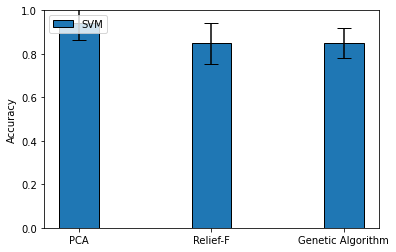

In [52]:
plot_classifier_metric('Accuracy', final_results)

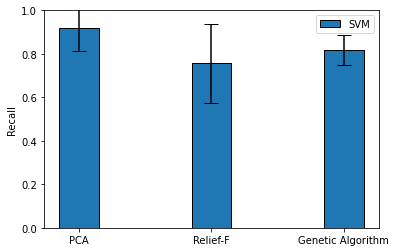

In [53]:
plot_classifier_metric('Recall', final_results)

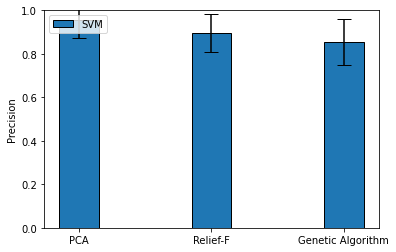

In [54]:
plot_classifier_metric('Precision', final_results)

In [103]:
from io import StringIO

def convert_confidence_interval(value):
    array = value.replace("[", "").replace("]", "").split(" ")
    return [ float(array[0]), float(array[1]) ]

naive_bayes_final_results_as_string = ',Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval\n5,All Features,0.6477290605088583,[0.400387 0.895072],0.7096774193548386,[0.411758 1.007597],0.618683309444179,[0.371354 0.866012]\n10,PCA,0.6467359478380954,[0.556482 0.73699],0.4927419354838709,[0.15926 0.826224],0.6748515499241777,[0.526396 0.823307]\n9,Relief-F,0.7098931065525771,[0.552904 0.866883],0.6395161290322581,[0.44671 0.832322],0.7182658164295527,[0.448781 0.987751]\n5,Genetic Algorithm,0.639985185249928,[0.409374 0.870596],0.6419354838709678,[0.365135 0.918736],0.6303124642670126,[0.336501 0.924123]\n'
naive_bayes_final_results = pd.read_csv(StringIO(naive_bayes_final_results_as_string))
del naive_bayes_final_results["Unnamed: 0"]
naive_bayes_final_results = naive_bayes_final_results.drop([0]) # remove a linha "All Features"
naive_bayes_final_results["Accuracy Confidence Interval"] = naive_bayes_final_results["Accuracy Confidence Interval"].apply(convert_confidence_interval)
naive_bayes_final_results["Recall Confidence Interval"] = naive_bayes_final_results["Recall Confidence Interval"].apply(convert_confidence_interval)
naive_bayes_final_results["Precision Confidence Interval"] = naive_bayes_final_results["Precision Confidence Interval"].apply(convert_confidence_interval)
naive_bayes_final_results

,Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
1,PCA,0.646736,"[0.556482, 0.73699]",0.492742,"[0.15926, 0.826224]",0.674852,"[0.526396, 0.823307]"
2,Relief-F,0.709893,"[0.552904, 0.866883]",0.639516,"[0.44671, 0.832322]",0.718266,"[0.448781, 0.987751]"
3,Genetic Algorithm,0.639985,"[0.409374, 0.870596]",0.641935,"[0.365135, 0.918736]",0.630312,"[0.336501, 0.924123]"


In [138]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_classifier(metric_name, dataset_labels, classifier_metrics):
    # width of the bars
    barWidth = 0.3
    i = 0
    
    for means, confidence_intervals, classifier in classifier_metrics:
        yer = list(map(lambda cf: (cf[1] - cf[0]) / 2, confidence_intervals))
        r = np.arange(len(means))

        plt.bar(r + (i * 0.25), means, width = barWidth, edgecolor = 'black', yerr=yer, capsize=7, label=classifier)
        i = i + 1

    # general layout
    total_metrics = len(dataset_labels)

    plt.xticks([r + (0.125) for r in range(total_metrics)], dataset_labels)
    plt.ylim(( 0, 1.25 ))
    plt.ylabel(metric_name)
    plt.legend()

    # Show graphic
    plt.show()
    
def plot_metric_classifier_for_metric(metric_name, results, classifiers):
    dataset_labels = results[0]['Datasets'].values
    classifier_metrics = []
    for i in range(len(results)):
        result = results[i]
        classifier = classifiers[i]
        
        classifier_metrics.append(
            (result[f'Mean {metric_name}'].values, result[f'{metric_name} Confidence Interval'].values, classifier)
        )
    plot_metric_classifier(metric_name, dataset_labels, classifier_metrics)

results = [naive_bayes_final_results, final_results]
classifiers = ['Naive-Bayes', 'SVM']

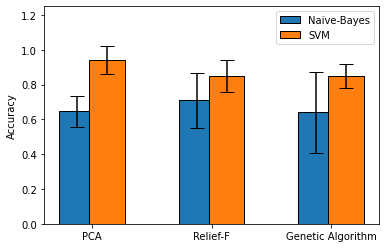

In [139]:
plot_metric_classifier_for_metric('Accuracy', results, classifiers)

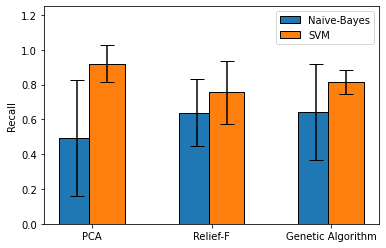

In [140]:
plot_metric_classifier_for_metric('Recall', results, classifiers)

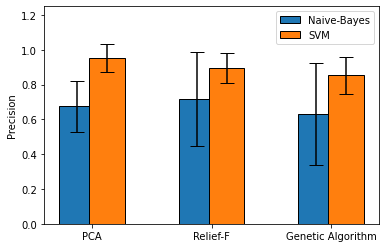

In [141]:
plot_metric_classifier_for_metric('Precision', results, classifiers)